In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import h5py
import warnings
from pathlib import Path
from v1dd_public import ARTIFACT_DIR
from scipy import stats
from v1dd_public import utils
from allen_v1dd.client import OPhysClient
from allen_v1dd.client.ophys_session import OPhysSession
from allen_v1dd.stimulus_analysis import LocallySparseNoise
import statsmodels.stats.multicomp as multi
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as patches
from collections import defaultdict
from scipy.stats import ks_2samp
from allen_v1dd.client import OPhysClient

np.random.seed(42) # set seed for reproducibility

In [3]:
mouse_ids = ["M409828", "M416296", "M427836", "M438833"]

## plotting parameters
from matplotlib import rcParams
rcParams['font.sans-serif'] = "Arial"
rcParams['font.family'] = "Arial"

fontsize=13
figure_path = Path('/home/naomi/Desktop/figures/v1dd_plots')

In [4]:
mouse_id = 'M427836'
col_vol_str = '23'
plane_name = f"Plane_1"
plane = 2 

In [5]:
DATA_DIR = Path("/home/naomi/Desktop/data/V1dd_nwbs")
assert DATA_DIR.exists()
DATA_DIR.resolve()

client = OPhysClient(DATA_DIR)
session = client.load_ophys_session(f"{mouse_id}_{col_vol_str}")
print(f'Loaded session {session.get_session_id()}, mouse {session.get_mouse_id()}, column {session.get_column_id()}, volume {session.get_volume_id()}')

lsn = LocallySparseNoise(session, plane, trace_type='events')
dff_traces = session.get_traces(plane, trace_type='dff')
valid_dff_traces = dff_traces[lsn.is_roi_valid, :].values
event_traces = session.get_traces(plane, trace_type='events')
valid_event_traces = event_traces[lsn.is_roi_valid, :].values

print(f'Loaded dff and event traces for {valid_dff_traces.shape[0]} valid ROIs')

Loaded session M427836_23, mouse 427836, column 2, volume 3
Loaded dff and event traces for 542 valid ROIs


In [6]:
s1, s2 = 8, 14
response_thresh_alpha = 0.05
nstd = 3
onset_delay = -1
offset_delay = 2
sample_spontaneous = 1000

all_lsn_vals_in_colvol_plane, all_pvals_in_colvol_plane, cell_indices  = utils.calc_lsn_p_vals_for_col_vol_plane(session,
                                    plane,
                                    sample_spontaneous,
                                    onset_delay,
                                    offset_delay)

design_matrix, trial_template, frame_images = utils.get_plane_lsn_constants(session)

In [266]:
# find On/Off subfield if it exists 
# for cell in range(542):
# cell = 541
# cell = np.random.choice(range(542))
cell = 313
for i in range(542):
    cell = i
    lsn_values = all_lsn_vals_in_colvol_plane[:, cell]
    pvals = all_pvals_in_colvol_plane[:, cell]
    is_trial_responsive = pvals < response_thresh_alpha
    num_responsive_trials = np.sum(is_trial_responsive)

    design_matrix_for_resp_trials = design_matrix[:, is_trial_responsive] # design matrix for responsive trials
    weighted_avg_for_resp_trials = design_matrix_for_resp_trials.dot(lsn_values[is_trial_responsive]) # weighted (by lsn value) average of responsive stimuli 

    # split into on and off trials
    weighted_avg_for_resp_trials_on = weighted_avg_for_resp_trials[:int(len(weighted_avg_for_resp_trials)/2)]
    weighted_avg_for_resp_trials_off = weighted_avg_for_resp_trials[int(len(weighted_avg_for_resp_trials)/2):]

    # calculate ON subfield (if it exists)
    on_pixels = design_matrix_for_resp_trials[:112].reshape(8, 14, design_matrix_for_resp_trials.shape[1]) # pull out the on pixels from "responsive trials"
    on_pixels = np.select([on_pixels == 1, on_pixels == 0], [255, 255/2], on_pixels)                       # convert to actual pixel values (for plotting later)
    mean_stim_for_resp_trials_on = on_pixels.mean(axis=2)                                                  # mean stimulus for on pixels of responsive trials
    mean_stim_for_resp_trials_on_weighted = (on_pixels * lsn_values[is_trial_responsive]).mean(axis=2)     # weighted mean stimulus for on pixels of responsive trials
    z_value_results_on = (mean_stim_for_resp_trials_on_weighted - mean_stim_for_resp_trials_on_weighted.mean()) / mean_stim_for_resp_trials_on_weighted.std() # z-score for on pixels
    counts_stim_for_resp_trials_on = design_matrix_for_resp_trials.sum(axis=1)[:112].reshape(8, 14)        # number of trials for each pixel
    on_results = (z_value_results_on > 2.5) & (counts_stim_for_resp_trials_on >= 7)  # threshold for significance

    # calculate OFF subfield (if it exists)
    off_pixels = design_matrix_for_resp_trials[112:].reshape(8, 14, design_matrix_for_resp_trials.shape[1])
    off_pixels = np.select([off_pixels == 1, off_pixels == 0], [0, 255/2], off_pixels)
    mean_stim_for_resp_trials_off = off_pixels.mean(axis=2)
    mean_stim_for_resp_trials_off_weighted = (off_pixels * lsn_values[is_trial_responsive]).mean(axis=2)     # weighted mean stimulus for on pixels of responsive trials
    z_value_results_off = (mean_stim_for_resp_trials_off_weighted - mean_stim_for_resp_trials_off_weighted.mean()) / mean_stim_for_resp_trials_off_weighted.std()
    counts_stim_for_resp_trials_off = design_matrix_for_resp_trials.sum(axis=1)[112:].reshape(8, 14)
    off_results = (z_value_results_off < -2.5) & (counts_stim_for_resp_trials_off >= 7)  # threshold for significance

    if on_results.sum() > 0:
        on_subfield = True
        on_subfield_pixels = np.where(on_results == True)
        on_center = np.mean(on_subfield_pixels, axis=1)
        # print(f'Cell {cell} has an ON subfield, {on_subfield_pixels}')

    if off_results.sum() > 0:
        off_subfield = True
        off_subfield_pixels = np.where(off_results == True)
        off_center = np.mean(off_subfield_pixels, axis=1)
        # print(f'Cell {cell} has an OFF subfield, {off_subfield_pixels}')
    
    if on_results.sum() > 0 and off_results.sum() > 0:
        print(f'Cell {cell} has both ON and OFF subfields')
        print(f'\tDistance between ON and OFF subfields {np.sqrt((on_center[0] - off_center[0])**2 + (on_center[1] - off_center[1])**2)}')

Cell 10 has both ON and OFF subfields
	Distance between ON and OFF subfields 1.2133516482134201
Cell 14 has both ON and OFF subfields
	Distance between ON and OFF subfields 6.670832032063167
Cell 21 has both ON and OFF subfields
	Distance between ON and OFF subfields 1.118033988749895
Cell 22 has both ON and OFF subfields
	Distance between ON and OFF subfields 5.220153254455275
Cell 25 has both ON and OFF subfields
	Distance between ON and OFF subfields 7.3824115301167
Cell 27 has both ON and OFF subfields
	Distance between ON and OFF subfields 5.335936864527374
Cell 34 has both ON and OFF subfields
	Distance between ON and OFF subfields 11.045361017187261
Cell 39 has both ON and OFF subfields
	Distance between ON and OFF subfields 4.123105625617661
Cell 40 has both ON and OFF subfields
	Distance between ON and OFF subfields 1.0
Cell 42 has both ON and OFF subfields
	Distance between ON and OFF subfields 4.743416490252569
Cell 44 has both ON and OFF subfields
	Distance between ON and O

Text(0.5, 0.95, 'Cell 541 Subfield Analysis')

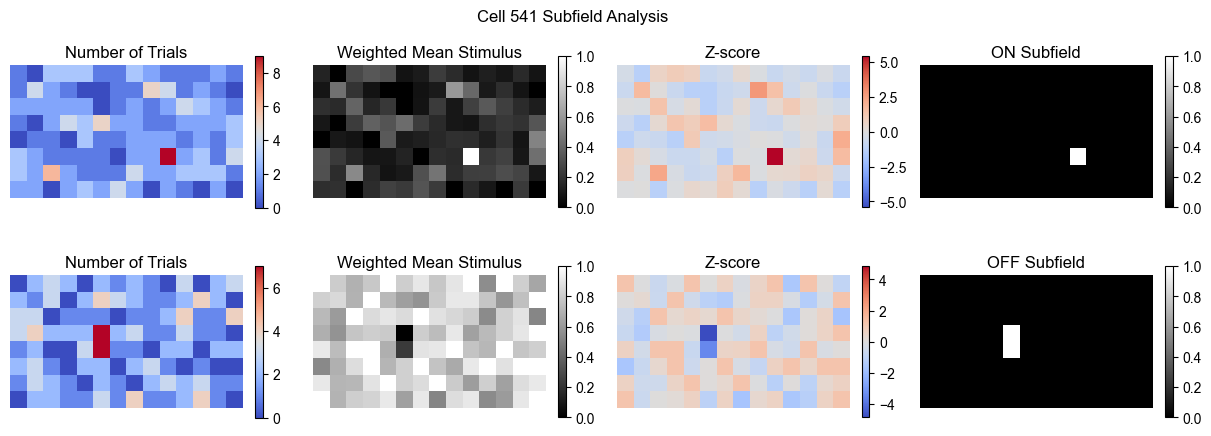

In [267]:
fig, axs = plt.subplots(2, 4, figsize=(15, 5))

# norm_mean_stim_for_resp_trials_on = (mean_stim_for_resp_trials_on - np.min(mean_stim_for_resp_trials_on)) / (np.max(mean_stim_for_resp_trials_on) - np.min(mean_stim_for_resp_trials_on))
# sub1 = axs[0, 0].imshow(norm_mean_stim_for_resp_trials_on, cmap='gray')
# fig.colorbar(sub1, ax=axs[0, 0], fraction=0.03)
# axs[0, 0].set_title('Mean Stimulus')
# axs[0, 0].axis('off')

sub1 = axs[0, 0].imshow(counts_stim_for_resp_trials_on, cmap='coolwarm')
fig.colorbar(sub1, ax=axs[0, 0], fraction=0.03)
axs[0, 0].set_title('Number of Trials')
axs[0, 0].axis('off')

norm_mean_stim_for_resp_trials_on_weighted = (mean_stim_for_resp_trials_on_weighted - np.min(mean_stim_for_resp_trials_on_weighted)) / (np.max(mean_stim_for_resp_trials_on_weighted) - np.min(mean_stim_for_resp_trials_on_weighted))
sub2 = axs[0, 1].imshow(norm_mean_stim_for_resp_trials_on_weighted, cmap='gray')
fig.colorbar(sub2, ax=axs[0, 1], fraction=0.03)
axs[0, 1].set_title('Weighted Mean Stimulus')
axs[0, 1].axis('off')

sub3 = axs[0, 2].imshow(z_value_results_on, cmap='coolwarm', vmin=-np.abs(z_value_results_on).max(), vmax=np.abs(z_value_results_on).max())
fig.colorbar(sub3, ax=axs[0, 2], fraction=0.03)
axs[0, 2].set_title('Z-score')
axs[0, 2].axis('off')

sub4 = axs[0, 3].imshow(on_results, cmap='gray', vmin=0, vmax=1)
fig.colorbar(sub4, ax=axs[0, 3], fraction=0.03)
axs[0, 3].set_title('ON Subfield')
axs[0, 3].axis('off')

sub1 = axs[1, 0].imshow(counts_stim_for_resp_trials_off, cmap='coolwarm')
fig.colorbar(sub1, ax=axs[1, 0], fraction=0.03)
axs[1, 0].set_title('Number of Trials')
axs[1, 0].axis('off')

norm_mean_stim_for_resp_trials_off_weighted = (mean_stim_for_resp_trials_off_weighted - np.min(mean_stim_for_resp_trials_off_weighted)) / (np.max(mean_stim_for_resp_trials_off_weighted) - np.min(mean_stim_for_resp_trials_off_weighted))
sub2 = axs[1, 1].imshow(norm_mean_stim_for_resp_trials_off_weighted, cmap='gray')
fig.colorbar(sub2, ax=axs[1, 1], fraction=0.03)
axs[1, 1].set_title('Weighted Mean Stimulus')
axs[1, 1].axis('off')

sub3 = axs[1, 2].imshow(z_value_results_off, cmap='coolwarm', vmin=-np.abs(z_value_results_off).max(), vmax=np.abs(z_value_results_off).max())
fig.colorbar(sub3, ax=axs[1, 2], fraction=0.03)
axs[1, 2].set_title('Z-score')
axs[1, 2].axis('off')

sub4 = axs[1, 3].imshow(off_results, cmap='gray', vmin=0, vmax=1)
fig.colorbar(sub4, ax=axs[1, 3], fraction=0.03)
axs[1, 3].set_title('OFF Subfield')
axs[1, 3].axis('off')

# plt.tight_layout()
fig.suptitle(f'Cell {cell} Subfield Analysis', y=0.95)

# plt.savefig(figure_path / f'cell_{cell}_subfield_analysis.png', dpi=300)

NameError: name 'mean_stim_for_resp_trials_on_weighted' is not defined

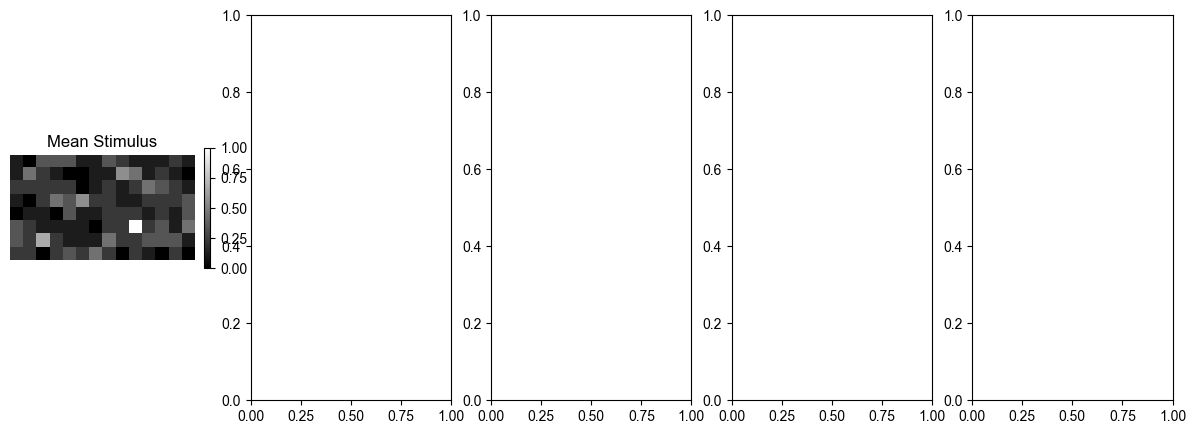

In [217]:
fig, axs = plt.subplots(1, 5, figsize=(15, 5))

norm_mean_stim_for_resp_trials_on = (mean_stim_for_resp_trials_on - np.min(mean_stim_for_resp_trials_on)) / (np.max(mean_stim_for_resp_trials_on) - np.min(mean_stim_for_resp_trials_on))
sub1 = axs[0].imshow(norm_mean_stim_for_resp_trials_on, cmap='gray')
fig.colorbar(sub1, ax=axs[0], fraction=0.03)
axs[0].set_title('Mean Stimulus')
axs[0].axis('off')

norm_mean_stim_for_resp_trials_on_weighted = (mean_stim_for_resp_trials_on_weighted - np.min(mean_stim_for_resp_trials_on_weighted)) / (np.max(mean_stim_for_resp_trials_on_weighted) - np.min(mean_stim_for_resp_trials_on_weighted))
sub2 = axs[1].imshow(norm_mean_stim_for_resp_trials_on_weighted, cmap='gray')
fig.colorbar(sub2, ax=axs[1], fraction=0.03)
axs[1].set_title('Weighted Mean Stimulus')
axs[1].axis('off')

sub3 = axs[2].imshow(z_value_results, cmap='coolwarm', vmin=-3, vmax=3)
fig.colorbar(sub3, ax=axs[2], fraction=0.03)
axs[2].set_title('Z-score')
axs[2].axis('off')

sub4 = axs[3].imshow(on_results, cmap='gray', vmin=0, vmax=1)
fig.colorbar(sub4, ax=axs[3], fraction=0.03)
axs[3].set_title('ON Subfield')
axs[3].axis('off')

sub5 = axs[4].imshow(off_results, cmap='gray_r', vmin=0, vmax=1)
fig.colorbar(sub5, ax=axs[4], fraction=0.03)
axs[4].set_title('OFF Subfield')
plt.xticks([])
plt.yticks([])

# plt.tight_layout()
fig.suptitle(f'Cell {cell} Subfield Analysis', y=0.7)

plt.savefig(figure_path / f'cell_{cell}_subfield_analysis.png', dpi=300)

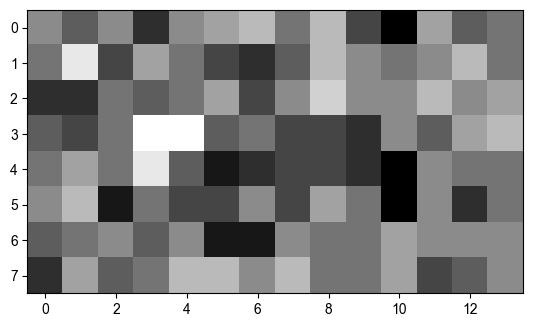

In [13]:
plt.imshow(mean_stim_for_resp_trials, cmap='gray')

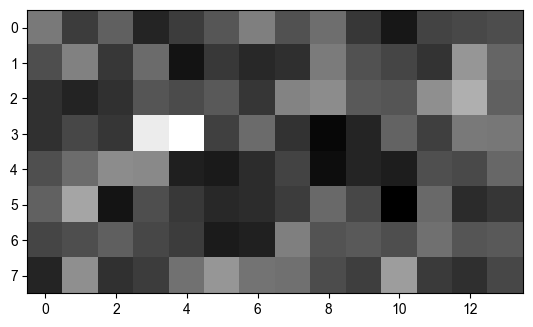

In [14]:
plt.imshow(mean_stim_for_resp_trials_weighted, cmap='gray')

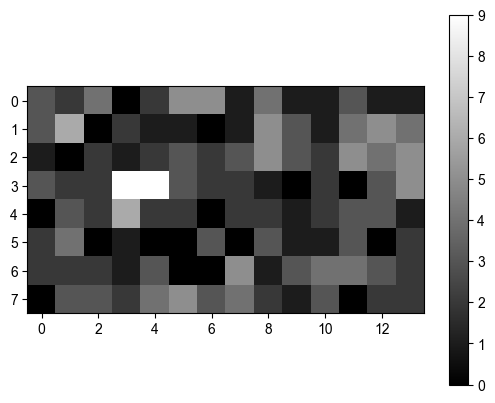

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0,0].imshow(design_matrix_for_resp_trials[])

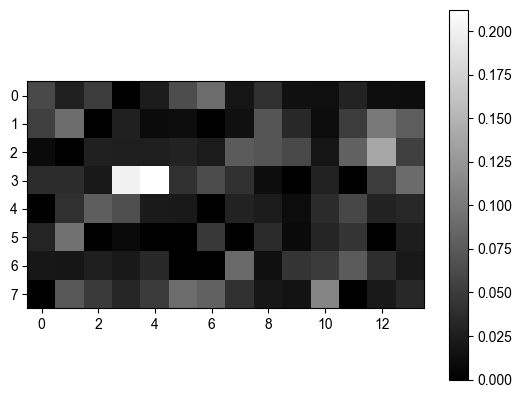

In [ ]:
plt.imshow(weighted_avg_for_resp_trials_on.reshape(8, 14), cmap='gray')
plt.colorbar()

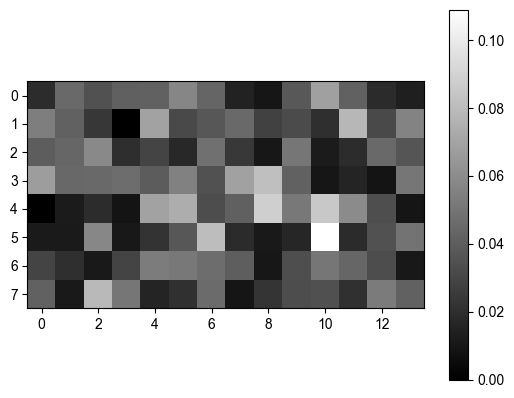

In [ ]:
plt.imshow(weighted_avg_for_resp_trials_off.reshape(8, 14), cmap='gray')
plt.colorbar()

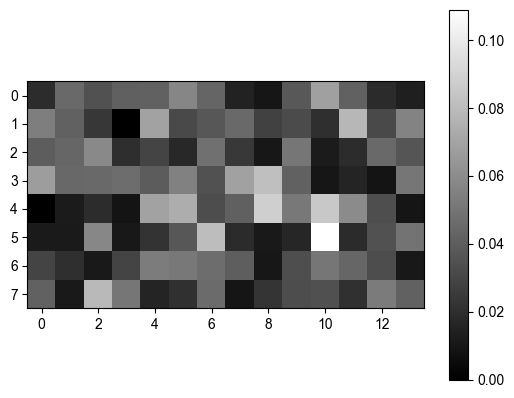

In [ ]:
plt.imshow(weighted_avg_for_resp_trials[-112:].reshape(8, 14), cmap='gray')
plt.colorbar()